Copy from https://wandb.ai/mostafaibrahim17/ml-articles/reports/An-Introduction-to-Audio-Classification-with-Keras--Vmlldzo0MDQzNDUy#:~:text=When%20using%20a%20Convolutional%20Neural,detect%20interesting%20patterns%20or%20structures.

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def load_data(data_path, metadata_path):
    features = []
    labels = []


    metadata = pd.read_csv(metadata_path)


    for index, row in metadata.iterrows():
        file_path = os.path.join(data_path, f"fold{row['fold']}", f"{row['slice_file_name']}")


        # Load the audio file and resample it
        target_sr = 22050
        audio, sample_rate = librosa.load(file_path, sr=target_sr)

        # Check if the audio length is less than the default n_fft size
        if len(audio) < 2048:
            # Pad the audio file with zeros
            audio = np.pad(audio, (0, 2048 - len(audio)), mode='constant')



        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=target_sr, n_mfcc=40)
        mfccs_scaled = np.mean(mfccs.T, axis=0)


        # Append features and labels
        features.append(mfccs_scaled)
        labels.append(row['class'])


    return np.array(features), np.array(labels)



In [3]:
data_path = "/Users/elaineran/Downloads/archive"
metadata_path = "/Users/elaineran/Downloads/archive/UrbanSound8K.csv"
features, labels = load_data(data_path, metadata_path)


# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_onehot = to_categorical(labels_encoded)


In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels_onehot, test_size=0.2, random_state=42, stratify=labels_onehot)


In [5]:
input_shape = (X_train.shape[1], 1)
model = Sequential()
model.add(Conv1D(64, 3, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(le.classes_), activation='softmax'))


In [6]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [8]:
def make_predictions(model, le, file_path):
    audio, sample_rate = librosa.load(file_path, sr=22050)
    mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=40)
    mfccs_scaled = np.mean(mfccs.T, axis=0)
    features = mfccs_scaled.reshape(1, mfccs_scaled.shape[0], 1)
    predicted_vector = model.predict(features)
    predicted_class_index = np.argmax(predicted_vector, axis=-1)
    return le.inverse_transform(predicted_class_index)[0]


In [10]:
# Save the initial weights
initial_weights = model.get_weights()


# Dictionary to store old predictions
old_predictions = {}
new_predictions = {}


# List of test files and their true labels
#test_files = [
    #("/Users/elaineran/Downloads/archive/fold1/101415-3-0-2.wav", "Dog bark"),
    #("/Users/elaineran/Downloads/archive/fold1/101415-3-0-3.wav", "Dog bark"),
    #("/Users/elaineran/Downloads/archive/fold1/102305-6-0-0.wav", "Gun shots"),
    #("/Users/elaineran/Downloads/archive/fold1/103074-7-0-2.wav", "Jack hammer"),
    #("/Users/elaineran/Downloads/archive/fold1/103074-7-4-3.wav", "Jack hammer")
#]


# Make predictions before training
#for file_path, true_label in test_files:
    #predicted_label_before = make_predictions(model, le, file_path)
    #old_predictions[file_path] = predicted_label_before


In [11]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Train on 6985 samples, validate on 1747 samples
Epoch 1/100
6985/6985 [==============================] - 10s 1ms/step - loss: 2.5657 - accuracy: 0.3243 - val_loss: 1.3631 - val_accuracy: 0.5581
Epoch 2/100
6985/6985 [==============================] - 9s 1ms/step - loss: 1.4642 - accuracy: 0.4932 - val_loss: 1.1034 - val_accuracy: 0.6600
Epoch 3/100
6985/6985 [==============================] - 9s 1ms/step - loss: 1.2632 - accuracy: 0.5632 - val_loss: 0.9038 - val_accuracy: 0.7064
Epoch 4/100
6985/6985 [==============================] - 9s 1ms/step - loss: 1.1143 - accuracy: 0.6208 - val_loss: 0.8110 - val_accuracy: 0.7504
Epoch 5/100
6985/6985 [==============================] - 9s 1ms/step - loss: 0.9992 - accuracy: 0.6661 - val_loss: 0.7149 - val_accuracy: 0.7813
Epoch 6/100
6985/6985 [==============================] - 9s 1ms/step - loss: 0.8992 - accuracy: 0.6971 - val_loss: 0.6417 - val_accuracy: 0.8082
Epoch 7/100
6985/6985 [==============================] - 9s 1ms/step - loss: 0.81

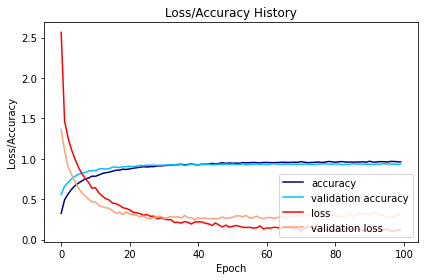

In [12]:
# plotting from history

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = list(range(len(loss)))

figsize = (6, 4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="validation accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="validation loss")


plots = plot1_loss + plot1_val_loss
labs = [plot.get_label() for plot in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Loss/Accuracy History")
plt.tight_layout()
axis1.legend(loc='lower right')
plt.show()

In [14]:
test_predictions = model.predict(X_test)

In [23]:
predicted_class_indices = np.argmax(test_predictions, axis=1)
predicted_classes = le.inverse_transform(predicted_class_indices)
print(predicted_classes)

['air_conditioner' 'street_music' 'dog_bark' ... 'dog_bark' 'jackhammer'
 'children_playing']


In [25]:
y_true = np.argmax(y_test, axis=1)
true_classes = le.inverse_transform(y_true)
print(true_classes)

['air_conditioner' 'street_music' 'dog_bark' ... 'dog_bark' 'jackhammer'
 'children_playing']


In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_true, predicted_class_indices)
print("Accuracy:", accuracy)

# Generate a classification report
print(classification_report(y_true, predicted_class_indices, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, predicted_class_indices)
print("Confusion Matrix:\n", cm)


Accuracy: 0.9341728677733258
                  precision    recall  f1-score   support

 air_conditioner       0.97      0.99      0.98       200
        car_horn       0.94      0.93      0.94        86
children_playing       0.85      0.91      0.88       200
        dog_bark       0.93      0.85      0.89       200
        drilling       0.97      0.93      0.95       200
   engine_idling       0.98      0.99      0.98       200
        gun_shot       0.96      0.88      0.92        75
      jackhammer       0.93      0.97      0.95       200
           siren       0.98      0.98      0.98       186
    street_music       0.86      0.88      0.87       200

        accuracy                           0.93      1747
       macro avg       0.94      0.93      0.93      1747
    weighted avg       0.94      0.93      0.93      1747

Confusion Matrix:
 [[199   0   0   0   0   0   0   0   0   1]
 [  2  80   0   0   0   0   0   2   0   2]
 [  2   1 181   5   0   2   2   0   0   7]
 [  1   

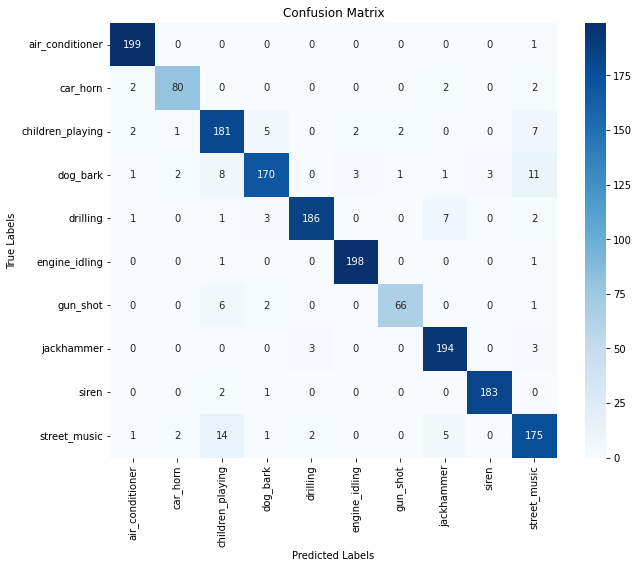

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
